# Задача 4. Удаление фона с помощью SVD (40 баллов)

Версия от 02.09.20.

В этой задаче мы познакомимся с одним из возможных приложений сингулярного разложения &mdash; удаление фона из видео.
Для этого сначала загрузим видео, на котором есть движущиеся объекты и неизменный фон.

In [2]:
import moviepy.editor as mpe
video = mpe.VideoFileClip("data_hw1/RPCA_video.mp4")
video.ipython_display(width=300, maxduration=250)

t:  15%|█▍        | 849/5761 [00:00<00:00, 8483.13it/s, now=None]

Moviepy - Building video __temp__.mp4.
Moviepy - Writing video __temp__.mp4



Moviepy - Done !
Moviepy - video ready __temp__.mp4


Импортируем необходимые библиотеки и представим видео в виде трехмерного массива размеров `(#пикселей по горизонтали) x (#пикселей по вертикали) x (#кадров)`.

In [3]:
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

In [4]:
duration = int(video.duration)
nframes = int(video.fps * video.duration)//2
size_h, size_w = video.size
arr = np.zeros([size_w, size_h, nframes])
for i in range(nframes):
    arr[:, :, i] = video.get_frame(i/nframes * duration)[:, :, 0].astype(np.float)
print('image size: {0:} x {1:}, \nnumber of frames: {2:}'.format(size_w, size_h, nframes))

image size: 60 x 80, 
number of frames: 2880


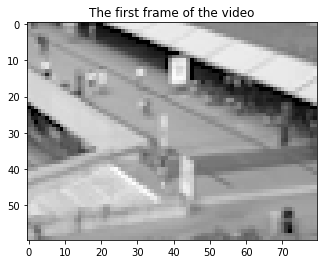

In [5]:
plt.imshow(arr[:, :, 0], cmap='gray')
_ = plt.title('The first frame of the video')

### a. Применение базового алгоритма SVD (18 баллов)

1. **(3 балла)** С помощью функции ```np.reshape(...)``` получите из трехмерного массива ```arr``` двумерных массив ```M``` размера ```(size_h * size_w) x nframes```, каждым столбцом которого является изображение размера ```size_h x size_w```, представленное в виде вектора с ```size_h * size_w``` элементами.

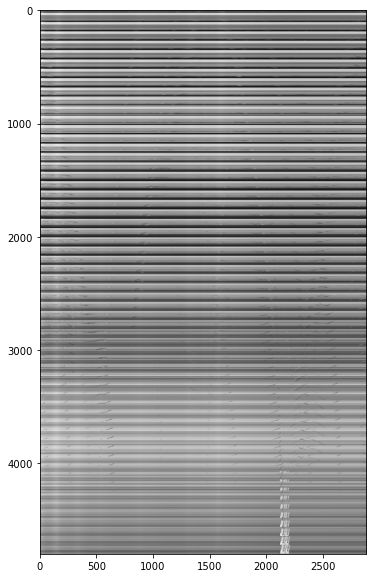

In [6]:
M = np.reshape(arr, (size_h * size_w, nframes))

plt.figure(figsize=(10, 10))
plt.imshow(M, cmap='gray')

2. **(5 баллов)** Вычислите сингулярное разложение матрицы ```M``` с помощью ```np.linalg.svd``` и постройте график сингулярных чисел, отсортированных по убыванию. Шкала с сингулярными числами должна быть логарифмической. Для этого, например, используйте функцию ```plt.semilogy```. Объясните, почему наибольшее и несколько наименьших (близких к 0) сингулярных число заметно отличается от остальных. 

**Замечание:** При построении графиков величин с отличающимися на порядки значениями полезно использовать логарифмическую шкалу. Чтобы убедиться в этом, попробуйте построить график не в логарифмической шкале; из него будет фактически невозможно понять характер убывания сингулярных чисел.

In [7]:
U, Si, Vh = np.linalg.svd(M)

In [13]:
print(U.shape)
print(Si.shape)
print(Vh.shape)
print(Si)

(4800, 4800)
(2880,)
(2880, 2880)
[4.99354249e+05 1.05077494e+04 6.83079901e+03 ... 2.86868137e-14
 2.57665706e-14 5.38761413e-15]


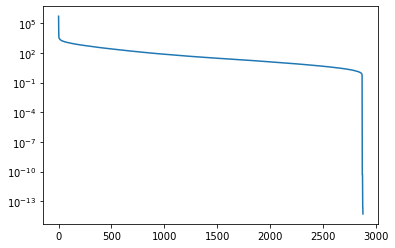

In [10]:
plt.semilogy(Si)

**Трактовка**

Знаем, что сингулярные числа тесно связаны со скелетным разложением матрицы, а именно: $M = \sum_{i = 1}^{r} \sigma_{i}u_{i}{v_{i}}^{T}$. То есть первое сингулярное число задаёт "основу" матрицы, остальные числа вносят менее заметные "уточнения". Исходя из смысла задачи, скорее всего первое сингулярное число отвечает за постоянный фон в кадре. В то же время, близкие к нулю числа почти никак не меняют элементы матрицы - вполне может быть, что они отвечают за артефакты в видео, возникающие при сжатии картинки (небольшие шумы). Однако скорее всего в реальном SVD-разложении матрицы M последние числа равны нулю, тогда как в numpy реализован вычислительный (не символьный) алгоритм, дающий "почти ноль". Отсюда такое резкое падение графика на последних элементах вектора сингулярных чисел.

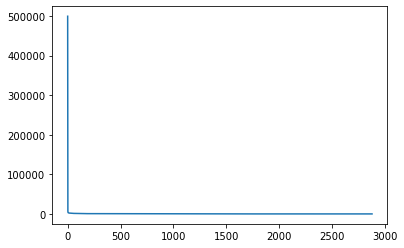

In [15]:
# попробуем построить график убывания сингулярных чисел без логарифмической шкалы. 
# да, ничего не понятно, ведь 1-ое число из 2880 уже на 2 порядка больше, чем 3-е
plt.plot(Si)

3. **(6 баллов)** Напишите функцию ```trunc_svd(M, r)```, которая считает оптимальное приближение $M_{r}$ двумерного массива $M$ заданного ранга, а также **относительную** точностью этого приближения в 2-норме, т.е. $$
\frac{\|M - M_{r}\|_2}{\|M\|_2}.
$$
Для вычисления относительной точности используйте только полученные из сингулярного разложения сингулярные числа.

In [34]:
def trunc_svd(M, r):
    '''
        Input
            M: 2D numpy array
            r: rank value for truncation
            
        Output
            Mr: 2D numpy array of the same size as M
            rel_eps: relative error of rank-r approximation Mr
    '''
    
    U, Si, Vh = np.linalg.svd(M)
    if r >= Si.shape[0]:
        print("r > rank(M), returning M")
        return M, 0
    
    Mr = U[:,:r] @ np.diag(Si[:r]) @ Vh[:r, :]
    rel_eps = Si[r] / Si[0]
    
    # TO BE FILLED
    
    return Mr, rel_eps

0.02104267547056409


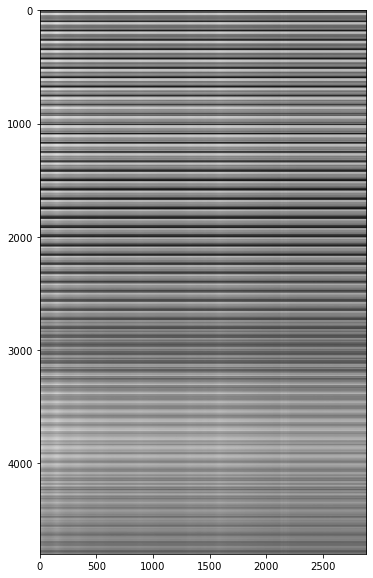

In [35]:
Mr, rel_eps = trunc_svd(M, 1)

print(rel_eps)
plt.figure(figsize=(10, 10))
plt.imshow(Mr, cmap='gray')

4. **(4 балла)** Используя написанную функцию найдите наилучшее приближение матрицы ```M``` матрицей ```M_svd``` ранга 1. С помощью ```plt.imshow(..., cmap='gray')``` постройте изображения первого кадра
    - исходного видео
    - фона (полученного из приближения ранга 1)
    - изображения людей (полученного с помощью изображений из предыдущих двух подпунктов)

In [74]:
def frame_decomposition(M, M_approx, frame_sz, frame_id=0):
    source = np.reshape(M[:, frame_id:frame_id + 1], frame_sz)
    background = np.reshape(M_approx[:, frame_id:frame_id + 1], frame_sz)
    foreground = np.reshape(M[:, frame_id:frame_id + 1] - M_approx[:, frame_id:frame_id + 1], frame_sz)
    return source, background, foreground

In [75]:
M_svd = Mr
source, background, foreground = frame_decomposition(M, M_svd, (size_w, size_h))

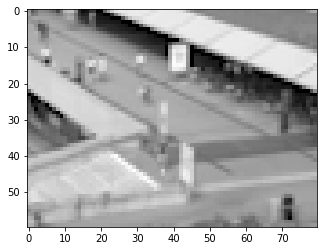

In [64]:
plt.imshow(source, cmap='gray')

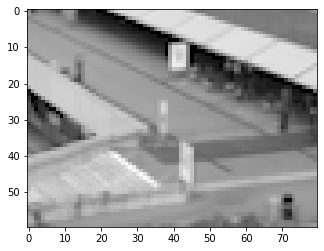

In [65]:
plt.imshow(background, cmap='gray')

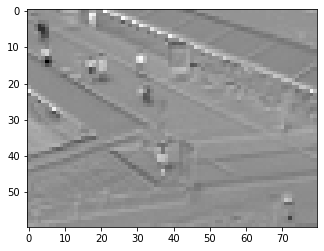

In [66]:
plt.imshow(foreground, cmap='gray')

### b. Применение рандомизированного алгоритма SVD (16 баллов)

Использование функции ```np.linalg.svd``` является эффективным для относительно небольших массивов из-за быстрого роста сложности алгоритма в зависимости от размера матрицы (об этом позже в курсе). Используем рандомизированный алгоритм из лекций для ускорения вычислений.

1. **(8 баллов)** Реализуйте рандомизированный алгоритм SVD из лекций, который аппроксимирует матрицу с заданным рангом $r$ (алгоритм заспускается с ```r + oversampling``` случайных векторов, после чего ранг обрезается до ```r``` с наименьшей ошибкой). Убедитесь, что вы **не вычисляете** в явном виде матрицу $QQ^*$.

In [71]:
def rand_svd(M, r, oversampling=10):
    '''
        Input
            M: 2D numpy array
            r: rank value for truncation
            oversampling: number of extra random vectors to approximate range(M)

        Output
            Mr: 2D numpy array of rank r and of the same size as M
            rel_eps: relative error of rank-r approximation Mr
    '''
    
    Omega = np.random.normal(size=(M.shape[1], r+oversampling))
    Y = M @ Omega
    Q, R = np.linalg.qr(Y)
    W, Si, Vt = np.linalg.svd(Q.T @ M)
    U = Q @ W
    
    Mr = U[:,:r] @ np.diag(Si[:r]) @ Vt[:r, :]
    rel_eps = np.linalg.norm(M - Mr, ord=2) / np.linalg.norm(M, ord=2)
    
    return Mr, rel_eps

2. **(2 балла)** Используя ```rand_svd```, найдите наилучшее приближение матрицы ```M``` матрицей ```M_rand``` ранга 1. С помощью ```plt.imshow(..., cmap='gray')``` постройте изображения первого кадра
    - исходного видео
    - фона (полученного из приближения ранга 1)
    - изображения людей (полученного с помощью изображений из предыдущих двух подпунктов)

In [91]:
M_rand, rel_eps_rand = rand_svd(M, 1)
print(M_rand.shape, rel_eps_rand)

(4800, 2880) 0.021194745004505654


In [90]:
source2, background2, foreground2 = frame_decomposition(M, M_rand, (size_w, size_h))

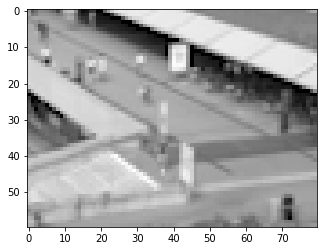

In [87]:
plt.imshow(source2, cmap='gray')

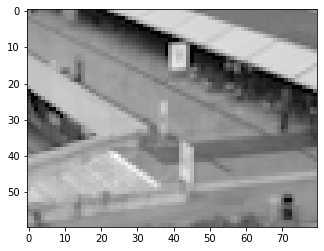

In [88]:
plt.imshow(background2, cmap='gray')

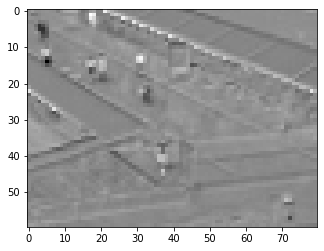

In [89]:
plt.imshow(foreground2, cmap='gray')

3. **(4 балла)** Постройте график функции
$$
\frac{||M_{rand}(p) - M||_2}{||M_{SVD} - M||_2} - 1
$$
в зависимости от $p$. По $p$ выберите сетку $[0, 100]$ с шагом 5.
Так как $M_{rand}(p)$ получено с помощью рандомизированного алгоритма, усредните Ваш результат, запустив алгоритм 10 раз.
При построении графика используйте логарифмическую шкалу.

In [109]:
def avg_deviation(Source, Approx2, p, iterations=10):
    sum = 0
    for _ in range(iterations):
        Approx1, _ = rand_svd(Source, 1, p)
        sum += np.linalg.norm(Approx1 - Source, ord=2) / np.linalg.norm(Approx2 - Source, ord=2) - 1
    avg = sum / 10
    print("p =", p, "sum =", avg)
    return avg

In [110]:
# должно быть avg вместо sum в принте, но запускать заново на час я это не буду...
p = np.linspace(0, 100, 21)
print(p)
avg_deviations = list()
for cur_p in p:
    avg_deviations.append(avg_deviation(M, M_svd, int(cur_p)))

[  0.   5.  10.  15.  20.  25.  30.  35.  40.  45.  50.  55.  60.  65.
  70.  75.  80.  85.  90.  95. 100.]
p = 0 sum = 3.27233835155359
p = 5 sum = 0.10864702531337098
p = 10 sum = 0.0085600721271607
p = 15 sum = 0.019718363749130476
p = 20 sum = 0.0005601943013049171
p = 25 sum = 0.000636882084604351
p = 30 sum = 0.00014800394116047942
p = 35 sum = 0.00012085069083140887
p = 40 sum = 0.00015929599985853304
p = 45 sum = 1.7995557980010625e-05
p = 50 sum = 3.1003335935952946e-05
p = 55 sum = 3.2591185501540385e-05
p = 60 sum = 1.8675273297485974e-05
p = 65 sum = 1.772517857703271e-05
p = 70 sum = 8.381779116950484e-06
p = 75 sum = 1.3553694571810659e-05
p = 80 sum = 8.139676258367423e-06
p = 85 sum = 3.3280915159084045e-06
p = 90 sum = 3.254106769090548e-06
p = 95 sum = 5.548217505446651e-06
p = 100 sum = 6.686018405743788e-06


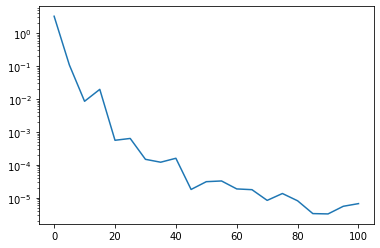

In [111]:
# видим, что если взять хотя бы 5 "лишних" векторов ошибка уже будет не такой большой, но если не взять ни одного
# вовсе, рандомизированный алгоритм выдаёт приближение, далёкое от правды
plt.semilogy(p, avg_deviations)

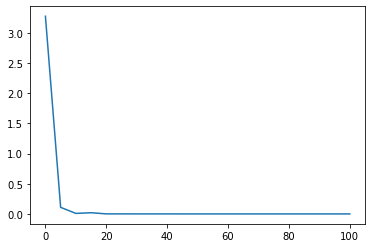

In [120]:
plt.plot(p, avg_deviations)

4. **(2 балла)** С помощью ```%timeit``` сравните время расчета для ```trunc_svd``` и ```rand_svd```. Во сколько раз рандомизированный алгоритм быстрее ```np.linalg.svd``` для матрицы ```M```?

In [117]:
# ради интереса ещё сделаем версию с фробениусовой нормой внутри
def rand_svd_frobenius(M, r, oversampling=10):
    '''
        Input
            M: 2D numpy array
            r: rank value for truncation
            oversampling: number of extra random vectors to approximate range(M)

        Output
            Mr: 2D numpy array of rank r and of the same size as M
            rel_eps: relative error of rank-r approximation Mr
    '''
    
    Omega = np.random.normal(size=(M.shape[1], r+oversampling))
    Y = M @ Omega
    Q, R = np.linalg.qr(Y)
    W, Si, Vt = np.linalg.svd(Q.T @ M)
    U = Q @ W
    
    Mr = U[:,:r] @ np.diag(Si[:r]) @ Vt[:r, :]
    rel_eps = np.linalg.norm(M - Mr) / np.linalg.norm(M)
    
    return Mr, rel_eps

In [118]:
%timeit tupleA = trunc_svd(M, 1)
%timeit tupleB = rand_svd(M, 1)
%timeit tupleC = rand_svd_frobenius(M, 1)
# рандомизированный алгоритм быстрее примерно в 2 раза, если использовать 2-норму для подсчёта ошибки
# и в 45 раз быстрее, если использовать фробениусову норму

14.3 s ± 569 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)
7.26 s ± 127 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)
305 ms ± 5.57 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)


### c. Robust PCA (6 баллов)

Заметим, что матрицу $M$ можно приближенно представить в виде $M = L + S$, где $L$ - малоранговая матрица, а $S$ - разреженная (то есть содержащая большое количество нулей). Для поиска $L$ и $S$ мы могли бы попытаться решить задачу

$$
    \mathrm{rank}(L) + \alpha\ \mathrm{nnz}(S) \to \min_{L,S}, \quad \alpha > 0
$$

при ограничении $M = L + S$, где $\mathrm{nnz}(S)$ обозначет число ненулевых элементов (<b>n</b>umber of <b>n</b>on<b>z</b>eros). 
Однако такую задачу решать крайне сложно из-за отсутвия непрерывности и выпуклости. 
Поэтому обычно ее [заменяют на более простую](https://arxiv.org/pdf/0912.3599.pdf):

$$
    \|L\|_* + \alpha \|S\|_{1} \to \min_{L, S}, \quad \alpha > 0,
$$

где $\|\cdot\|_*$ обозначает ядерную норму матрицы, а $\|\cdot\|_{1}$ является суммой модулей всех элементов матрицы ($\ell_1$-норма).

1. Скачайте код для вычисления robust PCA по ссылке [https://github.com/dganguli/robust-pca](https://github.com/dganguli/robust-pca) и импортируйте его.

In [51]:
# %load robust-pca/r_pca.py
from __future__ import division, print_function

import numpy as np

try:
    from pylab import plt
except ImportError:
    print('Unable to import pylab. R_pca.plot_fit() will not work.')

try:
    # Python 2: 'xrange' is the iterative version
    range = xrange
except NameError:
    # Python 3: 'range' is iterative - no need for 'xrange'
    pass


class R_pca:

    def __init__(self, D, mu=None, lmbda=None):
        self.D = D
        self.S = np.zeros(self.D.shape)
        self.Y = np.zeros(self.D.shape)

        if mu:
            self.mu = mu
        else:
            self.mu = np.prod(self.D.shape) / (4 * np.linalg.norm(self.D, ord=1))

        self.mu_inv = 1 / self.mu

        if lmbda:
            self.lmbda = lmbda
        else:
            self.lmbda = 1 / np.sqrt(np.max(self.D.shape))

    @staticmethod
    def frobenius_norm(M):
        return np.linalg.norm(M, ord='fro')

    @staticmethod
    def shrink(M, tau):
        return np.sign(M) * np.maximum((np.abs(M) - tau), np.zeros(M.shape))

    def svd_threshold(self, M, tau):
        U, S, V = np.linalg.svd(M, full_matrices=False)
        return np.dot(U, np.dot(np.diag(self.shrink(S, tau)), V))

    def fit(self, tol=None, max_iter=1000, iter_print=100):
        iter = 0
        err = np.Inf
        Sk = self.S
        Yk = self.Y
        Lk = np.zeros(self.D.shape)

        if tol:
            _tol = tol
        else:
            _tol = 1E-7 * self.frobenius_norm(self.D)

        #this loop implements the principal component pursuit (PCP) algorithm
        #located in the table on page 29 of https://arxiv.org/pdf/0912.3599.pdf
        while (err > _tol) and iter < max_iter:
            Lk = self.svd_threshold(
                self.D - Sk + self.mu_inv * Yk, self.mu_inv)                            #this line implements step 3
            Sk = self.shrink(
                self.D - Lk + (self.mu_inv * Yk), self.mu_inv * self.lmbda)             #this line implements step 4
            Yk = Yk + self.mu * (self.D - Lk - Sk)                                      #this line implements step 5
            err = self.frobenius_norm(self.D - Lk - Sk)
            iter += 1
            if (iter % iter_print) == 0 or iter == 1 or iter > max_iter or err <= _tol:
                print('iteration: {0}, error: {1}'.format(iter, err))

        self.L = Lk
        self.S = Sk
        return Lk, Sk

    def plot_fit(self, size=None, tol=0.1, axis_on=True):

        n, d = self.D.shape

        if size:
            nrows, ncols = size
        else:
            sq = np.ceil(np.sqrt(n))
            nrows = int(sq)
            ncols = int(sq)

        ymin = np.nanmin(self.D)
        ymax = np.nanmax(self.D)
        print('ymin: {0}, ymax: {1}'.format(ymin, ymax))

        numplots = np.min([n, nrows * ncols])
        plt.figure()

        for n in range(numplots):
            plt.subplot(nrows, ncols, n + 1)
            plt.ylim((ymin - tol, ymax + tol))
            plt.plot(self.L[n, :] + self.S[n, :], 'r')
            plt.plot(self.L[n, :], 'b')
            if not axis_on:
                plt.axis('off')


2. **(6 баллов)** Используйте класс ```R_pca``` и запустите функцию ```fit(max_iter=4000, iter_print=100)``` для нахождения матриц $L$ и $S$. С помощью ```plt.imshow(..., cmap='gray')``` постройте изображения первого кадра
    - исходного видео
    - фона (полученного из матрицы $L$)
    - изображения людей (полученного из матрицы $M$)

Обратите внимание, что на исходных данных метод может работать довольно долго (вероятно, часы). Поэтому предлагается взять только четверть временного ряда, а также вырезать каждый второй кадр.

In [54]:
M_short = M[:, :M.shape[1]//4:2]

rpca = R_pca(M_short)
L, S = rpca.fit(max_iter=4000, iter_print=100)

iteration: 1, error: 11.219585592031061
iteration: 100, error: 0.7158404252390286
iteration: 200, error: 0.5342741325551909
iteration: 300, error: 0.40019313074234114
iteration: 400, error: 0.32635610183223407
iteration: 500, error: 0.23899523820269364
iteration: 600, error: 0.1617736557006377
iteration: 700, error: 0.13657997623557305
iteration: 800, error: 0.11985458903728123
iteration: 900, error: 0.08149056184421188
iteration: 1000, error: 0.07517617420868791
iteration: 1100, error: 0.038893984790409265
iteration: 1200, error: 0.030900853212477958
iteration: 1300, error: 0.028478232537155517
iteration: 1309, error: 0.018371284055010442


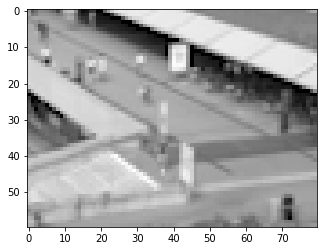

In [55]:
source_frame_1_R_pca = np.reshape(M_short[:, :1], (size_w, size_h))
plt.imshow(source_frame_1_R_pca, cmap='gray')

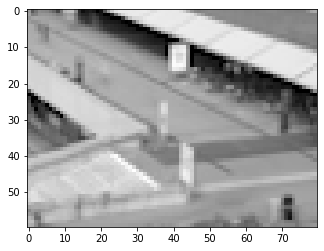

In [57]:
backgrnd_frame_1_R_pca = np.reshape(L[:, :1], (size_w, size_h))
plt.imshow(backgrnd_frame_1_R_pca, cmap='gray')

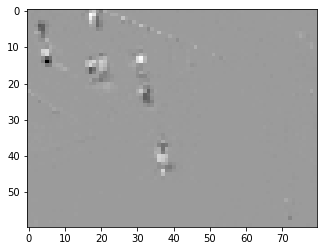

In [58]:
foregrnd_frame_1_R_pca = np.reshape(S[:, :1], (size_w, size_h))
plt.imshow(foregrnd_frame_1_R_pca, cmap='gray')

#ну вот, самое лучшее - не своё, а с гитхаба, как всегда..........